# Andrew Yang's Freedom Dividend

Estimate the effect of Andrew Yang's Freedom Dividend of $12,000 per year per adult age 18 to 64, funded by a 10 percent value-added tax and reducing benefits by up to the UBI amount for each tax unit.

*Data: CPS  |  Tax year: 2019  |  Type: Static  |  Author: Max Ghenis*

## Setup

### Imports

In [1]:
import taxcalc as tc
import taxcalc_helpers as tch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tc.__version__

'1.0.1'

### Settings

In [3]:
sns.set_style('white')
DPI = 200
mpl.rc('savefig', dpi=DPI)
mpl.rcParams['figure.dpi'] = DPI
mpl.rcParams['figure.figsize'] = 6.4, 4.8  # Default.

In [4]:
mpl.rcParams['font.sans-serif'] = 'Roboto'
mpl.rcParams['font.family'] = 'sans-serif'

# Set title text color to dark gray (https://material.io/color) not black.
TITLE_COLOR = '#212121'
mpl.rcParams['text.color'] = TITLE_COLOR

# Axis titles and tick marks are medium gray.
AXIS_COLOR = '#757575'
mpl.rcParams['axes.labelcolor'] = AXIS_COLOR
mpl.rcParams['xtick.color'] = AXIS_COLOR
mpl.rcParams['ytick.color'] = AXIS_COLOR

# Use Seaborn's default color palette.
# https://stackoverflow.com/q/48958426/1840471 for reproducibility.
sns.set_palette(sns.color_palette())

In [5]:
# Show one decimal in tables.
pd.set_option('precision', 2)

## Data

In [6]:
recs = tc.Records.cps_constructor()

In [41]:
BENS = ['other_ben', 'snap_ben', 'ssi_ben', 'tanf_ben', 'wic_ben']

In [64]:
base = tch.calc_df(records=recs, year=2019, 
                   group_vars=['XTOT', 'nu18'] + BENS,
                   group_n65=True,
                   metric_vars=['aftertax_income', 'XTOT'])
tch.add_weighted_quantiles(base, 'aftertax_income')

### Calculations

In [65]:
UBI = 12000
base['bens'] = base[BENS].sum(axis=1)
base['adults'] = base.XTOT - base.n65 - base.nu18
base['ubi_max'] = base.adults * UBI
base['ubi'] = np.where(base.ubi_max > base.bens, base.ubi_max - base.bens, 0)

Weight.

In [66]:
base['ubi_m'] = base.ubi * base.s006 / 1e6
base['ubi_max_m'] = base.ubi_max * base.s006 / 1e6
base['bens_m'] = base.bens * base.s006 / 1e6

In [67]:
base.ubi_m.sum()

2046415.1640859575

In [68]:
base.ubi_max_m.sum()

2377812.78564

In [69]:
base.ubi_max_m.sum() - base.ubi_m.sum()

331397.62155404245

In [70]:
base.bens_m.sum()

461648.64029236435

### VAT

Start with equal incidence, then re-weight according to Brookings paper.

In [71]:
TOTAL_VAT = 800e9

In [100]:
base['afti_yang_prevat'] = base.aftertax_income + base.ubi
base['afti_yang_prevat_noneg'] = base.afti_yang_prevat.clip_lower(0)

In [73]:
base.afti_yang_prevat.median() - base.aftertax_income.median()

14500.536719064417

In [103]:
base['vat'] = (TOTAL_VAT * base.afti_yang_prevat_noneg / 
               tch.weighted_sum(df=base, col='afti_yang_prevat_noneg'))

In [104]:
base['afti_yang'] = base.afti_yang_prevat - base.vat

In [105]:
tch.gini(base.aftertax_income, base.s006)

0.45102436073606167

In [106]:
tch.gini(base.afti_yang, base.s006)

0.4029194074126732

In [107]:
base.afti_yang.describe()

count    4.56e+05
mean     1.41e+05
std      1.51e+06
min     -3.11e+06
25%      4.90e+04
50%      9.28e+04
75%      1.70e+05
max      1.01e+09
Name: afti_yang, dtype: float64

In [108]:
base['afti_chg'] = base.afti_yang - base.aftertax_income
base['afti_chg_m'] = base.afti_chg * base.s006 / 1e6

In [109]:
tch.weighted_sum(base, 'afti_chg') / 1e9

1246.4151640859568

## Analysis

In [147]:
base.sort_values('afti).head()

,other_ben,aftertax_income,s006,wic_ben,tanf_ben,snap_ben,ssi_ben,XTOT,nu18,n65,...,bens_m,afti_yang_prevat,vat,afti_yang,afti_chg,afti_chg_m,afti_yang_prevat_noneg,fpl,fpl_base_m,fpl_yang_m
RECID,,,,,,,,,,,,,,,,,,,,,
267908,0.0,1.07e+09,34.56,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,1.07e+09,5.92e+07,1.01e+09,-5.92e+07,-2045.56,1.07e+09,16460.0,0.0,0.0
255188,0.0,3.78e+07,172.45,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,3.78e+07,2.09e+06,3.57e+07,-2.09e+06,-361.15,3.78e+07,16460.0,0.0,0.0
376925,0.0,3.45e+07,36.87,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,3.46e+07,1.92e+06,3.26e+07,-1.89e+06,-69.80,3.46e+07,16460.0,0.0,0.0
74828,0.0,2.99e+07,7.23,0.0,0.0,0.0,0.0,2.0,0.0,2.0,...,0.0,2.99e+07,1.66e+06,2.83e+07,-1.66e+06,-12.00,2.99e+07,16460.0,0.0,0.0
81421,0.0,2.97e+07,69.77,0.0,0.0,0.0,0.0,3.0,1.0,0.0,...,0.0,2.97e+07,1.65e+06,2.81e+07,-1.63e+06,-113.39,2.97e+07,20780.0,0.0,0.0


In [110]:
base.sort_values('afti_chg', ascending=False).head()

,other_ben,aftertax_income,s006,wic_ben,tanf_ben,snap_ben,ssi_ben,XTOT,nu18,n65,...,ubi,ubi_m,ubi_max_m,bens_m,afti_yang_prevat,vat,afti_yang,afti_chg,afti_chg_m,afti_yang_prevat_noneg
RECID,,,,,,,,,,,,,,,,,,,,,
167613,0.0,2935.90,877.33,0.0,0.0,0.0,0.0,12.0,0.0,0.0,...,144000.0,126.34,126.34,0.0,146935.90,8149.89,138786.01,135850.11,119.19,146935.90
388397,0.0,0.00,550.97,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,84000.0,46.28,46.28,0.0,84000.00,4659.11,79340.89,79340.89,43.71,84000.00
201242,0.0,20623.71,107.18,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,84000.0,9.00,9.00,0.0,104623.71,5803.02,98820.69,78196.98,8.38,104623.71
201244,0.0,20623.71,107.18,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,84000.0,9.00,9.00,0.0,104623.71,5803.02,98820.69,78196.98,8.38,104623.71
201245,0.0,20623.71,107.18,0.0,0.0,0.0,0.0,7.0,0.0,0.0,...,84000.0,9.00,9.00,0.0,104623.71,5803.02,98820.69,78196.98,8.38,104623.71


In [115]:
decile = base.groupby('aftertax_income_decile')['aftertax_income_m', 'afti_chg_m', 's006'].sum()
decile['afti_chg'] = 1e6 * decile.afti_chg_m / decile.s006
decile['afti_chg_pct'] = decile.afti_chg_m / decile.aftertax_income_m
decile

,aftertax_income_m,afti_chg_m,s006,afti_chg,afti_chg_pct
aftertax_income_decile,,,,,
0,-1.26e+04,634.60,4.98e+04,12738.39,-5.06e-02
1,1.65e+05,172089.67,1.65e+07,10444.44,1.04e+00
2,3.87e+05,160118.45,1.65e+07,9688.69,4.14e-01
3,5.18e+05,132497.67,1.65e+07,8017.63,2.56e-01
4,6.45e+05,132566.80,1.65e+07,8021.40,2.06e-01
5,7.93e+05,135509.72,1.65e+07,8199.86,1.71e-01
6,9.76e+05,123548.45,1.65e+07,7475.15,1.27e-01
7,1.21e+06,126934.51,1.65e+07,7680.95,1.05e-01
8,1.52e+06,126931.11,1.65e+07,7680.40,8.35e-02


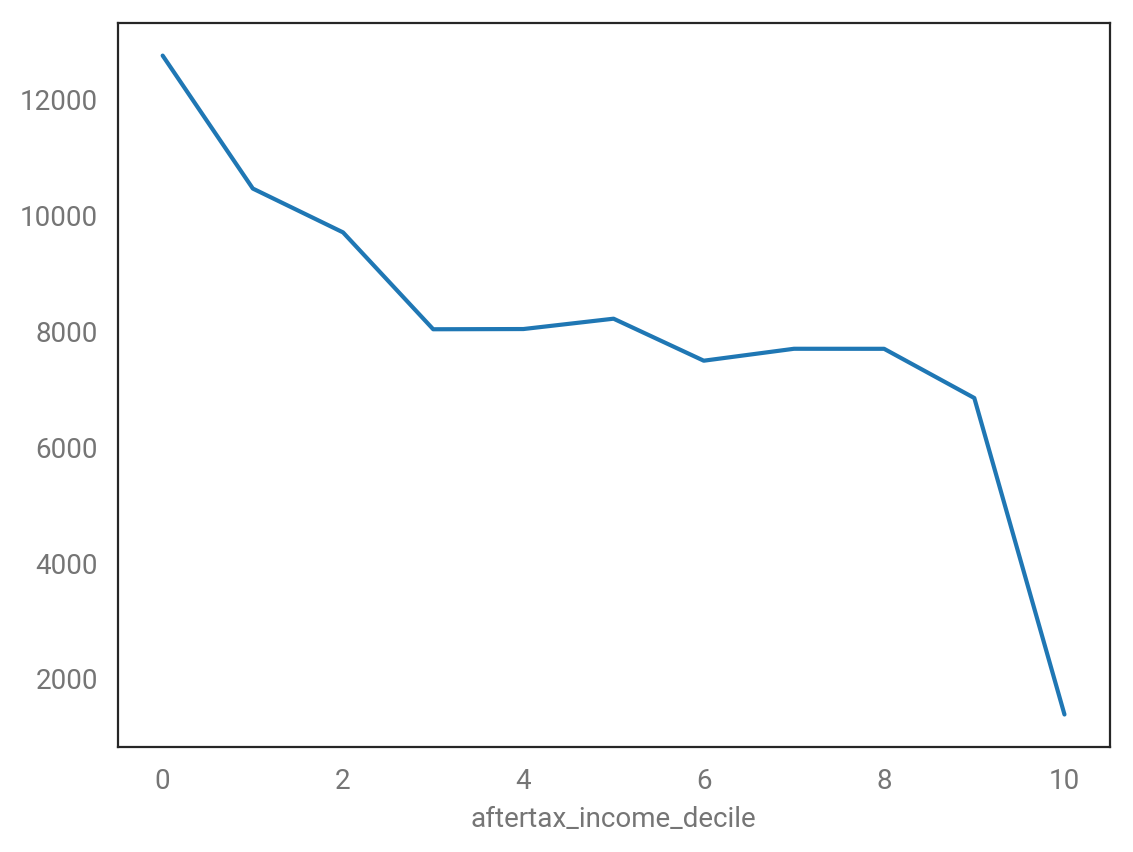

In [112]:
decile.afti_chg.plot()
plt.show()

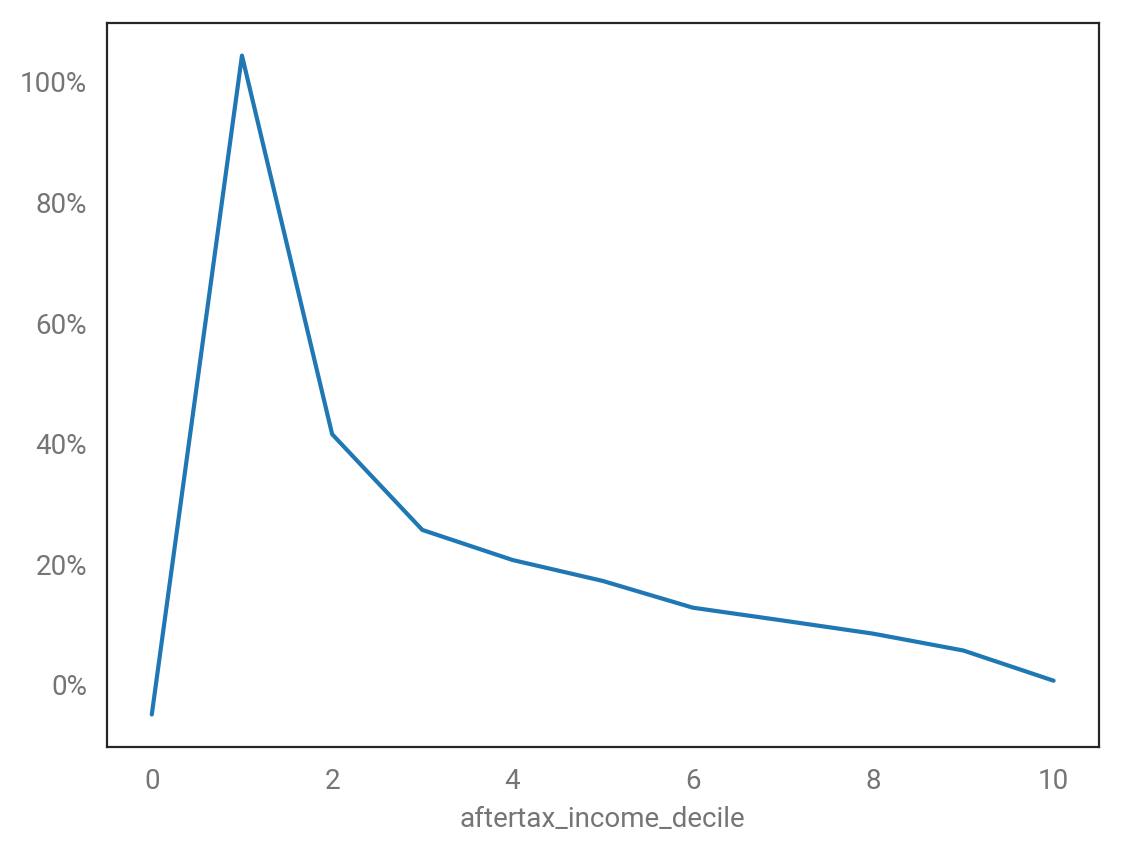

In [118]:
ax = decile.afti_chg_pct.plot()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))
plt.show()

In [120]:
ventile = base.groupby('aftertax_income_ventile')['aftertax_income_m', 'afti_chg_m', 's006'].sum()
ventile['afti_chg'] = 1e6 * ventile.afti_chg_m / ventile.s006
ventile['afti_chg_pct'] = ventile.afti_chg_m / ventile.aftertax_income_m
ventile

,aftertax_income_m,afti_chg_m,s006,afti_chg,afti_chg_pct
aftertax_income_ventile,,,,,
0,-1.26e+04,634.60,4.98e+04,12738.39,-5.06e-02
5,3.87e+04,86670.55,8.21e+06,10552.88,2.24e+00
10,1.26e+05,85419.13,8.26e+06,10336.66,6.75e-01
15,1.75e+05,84478.82,8.26e+06,10223.46,4.84e-01
20,2.12e+05,75639.63,8.26e+06,9153.92,3.57e-01
25,2.44e+05,68882.07,8.26e+06,8335.78,2.82e-01
30,2.74e+05,63615.60,8.26e+06,7699.45,2.32e-01
35,3.06e+05,64797.64,8.26e+06,7840.81,2.12e-01
40,3.39e+05,67769.16,8.26e+06,8202.03,2.00e-01


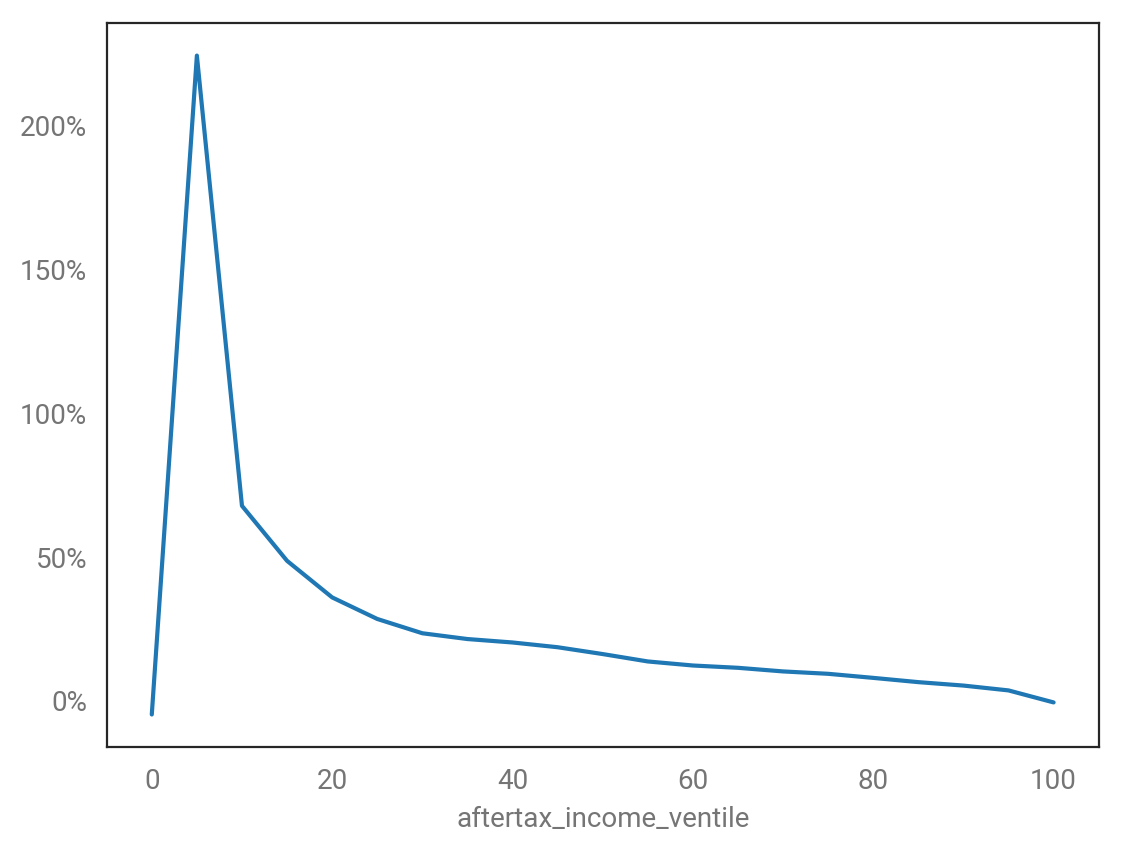

In [122]:
ax = ventile.afti_chg_pct.plot()
ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, _: '{:.0%}'.format(y)))
plt.show()

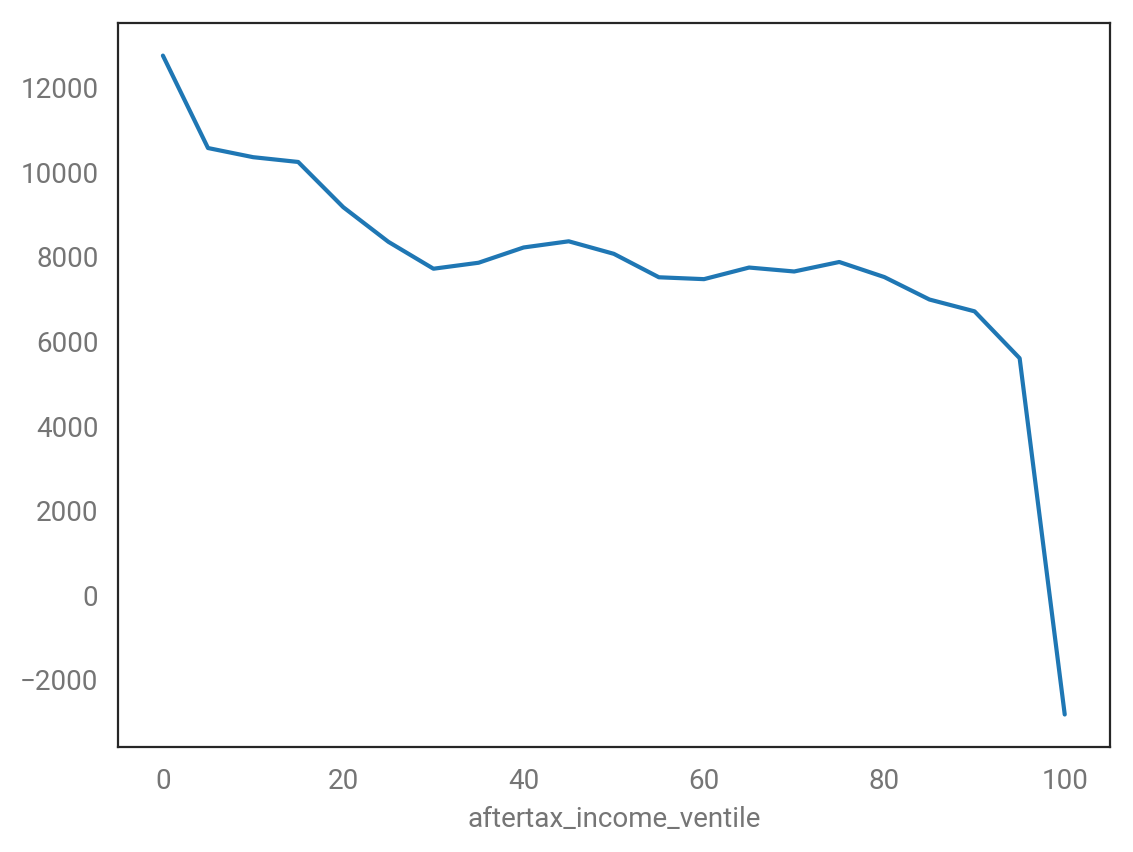

In [114]:
ventile.afti_chg.plot()
plt.show()

### Poverty

In [137]:
base['fpl'] = tch.fpl(base.XTOT)
base['fpl_base_m'] = base.XTOT_m * (base.aftertax_income < base.fpl)
base['fpl_yang_m'] = base.XTOT_m * (base.afti_yang < base.fpl)

In [138]:
base.fpl_base_m.sum() / base.XTOT_m.sum()

0.05053883636467064

In [139]:
base.fpl_yang_m.sum() / base.XTOT_m.sum()

0.013771445987322386

In [146]:
base[base.fpl_base_m < base.fpl_yang_m].adults.describe()

count    146.00
mean       0.04
std        0.20
min        0.00
25%        0.00
50%        0.00
75%        0.00
max        1.00
Name: adults, dtype: float64